In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import vmap, jit
import matplotlib.pyplot as plt
import joblib
from qdots_qll.models import game
from qdots_qll import all_funcs
import seaborn as sns
import pandas as pd
import scipy
from functools import reduce

In [2]:
import matplotlib.font_manager as font_manager

# Add every font at the specified location
# font_dir = ["/Users/darioradecic/Downloads/Merriweather"]
# for font in font_manager.findSystemFonts(font_dir):
#     font_manager.fontManager.addfont(font)

# font_manager.get_font_names()


from matplotlib import rcParams

rcParams["font.family"] = "Lato"

sns.set_palette("colorblind")

In [3]:
names_true = [
    "$\\gamma ( - \\eta)$",
    "$\\gamma ( + \\eta)$",
    "$S ( - \\eta)$",
    "$S ( +\\eta)$",
]
names_hat = [
    "$\\hat{\\gamma} ( - \\eta)$",
    "$\\hat{\\gamma} ( + \\eta)$",
    "$\\hat{S} ( - \\eta)$",
    "$\\hat{S} ( +\\eta)$",
]

In [4]:
# OPTIMIZED
# run_results = joblib.load("../results/run_2024-01-16_18:42:07_results.job")
# run_model = joblib.load("../results/run_2024-01-16_18:42:07_model.job")

# NON OPTIMIZED

run_results_random_times = joblib.load(
    "../results/run_2024-01-17_11:07:58_results.job"
)
run_model_random_times = joblib.load(
    "../results/run_2024-01-17_11:07:58_model.job"
)

# det optimized

run_results_det_optimized = joblib.load(
    "../results/run_2024-01-22_20:29:42_results.job"
)
run_model_det_optimized = joblib.load(
    "../results/run_2024-01-22_20:29:42_model.job"
)


true_parameters = game.true_pars

number_of_samples = 500

iters = np.arange(0, 4000)

In [5]:
def f_to_replace_with_nan(covariances, iteration):
    arr = np.array(covariances)
    arr[iteration + 1 :] = np.nan
    return arr


def return_cov_mse_per_step(results_run, true_parameters, number_of_samples):
    np_cov_arr = np.array(results_run.cov_array)
    np_estimates_arr = np.array(results_run.estimates_array)
    np_iter = np.array(results_run.iteration)

    for i in range(number_of_samples):
        np_cov_arr[i] = f_to_replace_with_nan(np_cov_arr[i], np_iter[i])
        np_estimates_arr[i] = f_to_replace_with_nan(
            np_estimates_arr[i], np_iter[i]
        )

    all_runs_diff_squared = (true_parameters - np_estimates_arr) ** 2

    mse_array_mean = np.nanmean(
        np.nanmean(all_runs_diff_squared, axis=2), axis=0
    )
    mse_array_median = np.nanmedian(
        np.nanmean(all_runs_diff_squared, axis=2), axis=0
    )

    mse_array_std = np.nanstd(
        np.nanmean(all_runs_diff_squared, axis=2), axis=0
    )

    cov_norm_array = jax.vmap(
        lambda a: vmap(jnp.linalg.norm, (0))(a), in_axes=(0)
    )(np_cov_arr)

    cov_norm_array_mean = np.nanmean(cov_norm_array, axis=0)
    cov_norm_array_median = np.nanmedian(cov_norm_array, axis=0)
    cov_norm_array_std = np.nanstd(cov_norm_array, axis=0)

    return [
        [
            cov_norm_array,
            [cov_norm_array_mean, cov_norm_array_median, cov_norm_array_std],
        ],
        [
            all_runs_diff_squared,
            [mse_array_mean, mse_array_median, mse_array_std],
        ],
    ]

In [5]:
[
    [
        cov_norm_array,
        [cov_norm_array_mean, cov_norm_array_median, cov_norm_array_std],
    ],
    [
        mse_array,
        [mse_array_mean, mse_array_median, mse_array_std],
    ],
] = return_cov_mse_per_step(
    run_results_random_times, true_parameters, number_of_samples
)

NameError: name 'return_cov_mse_per_step' is not defined

In [ ]:
# run_results_random_times = None
# run_model_random_times = None

# run_results_det_optimized = None
# run_model_det_optimized = None

In [164]:
df = run_results_det_optimized
df

Run(
  iteration=i32[500],
  key=u32[500,2],
  weights=f32[500,2000],
  particles_locations=f32[500,2000,4],
  max_iterations=i32[500],
  min_iterations=i32[500],
  std_threshold=f32[500],
  cov_array=f32[500,4000,4,4],
  estimates_array=f32[500,4000,4],
  times_array=f32[500,4000]
)

In [161]:
df

In [25]:
df.cov_array[0, 0]

Array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)

In [165]:
# df = run_results_random_times
cov_arr = df.cov_array[:, 1:]
cumulative_times_per_run = (
    vmap(jnp.cumsum, in_axes=(0))(df.times_array) * 10
)[:, 1:]

var_arr = vmap(vmap(lambda x: jnp.diag(x), in_axes=(0)), in_axes=(0))(cov_arr)

array([[[5.8846757e-02, 4.5053571e-02, 3.9776815e-03, 6.7473322e-02],
        [5.2188285e-02, 4.1946352e-02, 4.0017031e-03, 6.0618490e-02],
        [5.0611541e-02, 4.0269732e-02, 4.0100105e-03, 6.1677843e-02],
        ...,
        [6.5475702e-05, 7.7232718e-05, 6.7400513e-05, 1.6397238e-04],
        [6.5214932e-05, 7.7053905e-05, 6.7579560e-05, 1.6468763e-04],
        [6.4939260e-05, 7.7083707e-05, 6.7843823e-05, 1.6528368e-04]],

       [[5.8491617e-02, 6.4359948e-02, 3.8214307e-03, 6.6112697e-02],
        [5.9817612e-02, 5.9254229e-02, 3.7236689e-03, 5.6768641e-02],
        [5.6994364e-02, 4.8063703e-02, 3.3402285e-03, 2.3819309e-02],
        ...,
        [6.9133937e-05, 6.4179301e-05, 6.9582369e-05, 1.6873330e-04],
        [6.9253147e-05, 6.4149499e-05, 6.9600297e-05, 1.6891956e-04],
        [6.9230795e-05, 6.4253807e-05, 6.9489237e-05, 1.6888231e-04]],

       [[6.3877150e-02, 6.4158961e-02, 3.6322223e-03, 4.3002121e-02],
        [5.8612391e-02, 6.0523197e-02, 3.7187077e-03, 3.6919

In [166]:
var_arr = np.array(var_arr)
cumulative_times_per_run = np.array(cumulative_times_per_run)

In [167]:
max_lim_bin = int(8.6e5)
no_bins = int(100)
limites_bins = np.arange(
    0.0,
    max_lim_bin,
    np.floor(max_lim_bin / no_bins),
)

In [81]:
def compute_mean_one_run(cum_times_i, cov_arr_i, limites_bins):
    indices_bins = np.digitize(cum_times_i, limites_bins)
    means = np.array(
        [
            np.nanmean(cov_arr_i[indices_bins == i], axis=0)
            for i in range(1, len(limites_bins))
        ]
    )

    std_devs = np.array(
        [
            np.nanstd(cov_arr_i[indices_bins == i], axis=0)
            for i in range(1, len(limites_bins))
        ]
    )
    return means, std_devs

In [121]:
j = 4
compute_mean_one_run(cumulative_times_per_run[j], cov_arr[j], limites_bins)

/tmp/ipykernel_159826/3441403363.py:5: RuntimeWarning: Mean of empty slice
  np.nanmean(cov_arr_i[indices_bins == i], axis=0)


(array([[[ 0.01961338,  0.00494186,  0.00061065, -0.0004    ],
         [ 0.00494186,  0.02103465,  0.00043354, -0.00029499],
         [ 0.00061065,  0.00043354,  0.00309334,  0.0032205 ],
         [-0.0004    , -0.00029499,  0.0032205 ,  0.0219362 ]],
 
        [[ 0.00585699,  0.00155547,  0.00026016,  0.00026187],
         [ 0.00155547,  0.00496284,  0.00023727,  0.00031078],
         [ 0.00026016,  0.00023727,  0.00204747,  0.00276037],
         [ 0.00026187,  0.00031078,  0.00276037,  0.0053133 ]],
 
        [[ 0.00381647,  0.00101694,  0.0001918 ,  0.00023787],
         [ 0.00101694,  0.00305365,  0.00024894,  0.00041293],
         [ 0.0001918 ,  0.00024894,  0.00166486,  0.00225577],
         [ 0.00023788,  0.00041293,  0.00225577,  0.00415003]],
 
        ...,
 
        [[        nan,         nan,         nan,         nan],
         [        nan,         nan,         nan,         nan],
         [        nan,         nan,         nan,         nan],
         [        nan,         

In [168]:
all_mean_stds = np.array(
    [
        compute_mean_one_run(
            cumulative_times_per_run[j], cov_arr[j], limites_bins
        )
        for j in range(len(cov_arr))
    ]
).swapaxes(0, 1)

/tmp/ipykernel_159826/3441403363.py:5: RuntimeWarning: Mean of empty slice
  np.nanmean(cov_arr_i[indices_bins == i], axis=0)
/home/antonio/miniconda3/envs/jax_qdots/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [169]:
all_mean_agg_binned = np.nanmean(all_mean_stds, axis=1)[0]
all_std_agg_binned = np.nanstd(all_mean_stds, axis=1)[0]

/tmp/ipykernel_159826/2900979578.py:1: RuntimeWarning: Mean of empty slice
  all_mean_agg_binned = np.nanmean(all_mean_stds, axis=1)[0]


In [170]:
# det_mean_agg_binned = all_mean_agg_binned
# det_std_agg_binned = all_std_agg_binned

In [158]:
# random_mean_agg_binned = all_mean_agg_binned
# random_std_agg_binned = all_std_agg_binned

In [151]:
from qdots_qll.models.game import *
import qutip as qt
from functools import reduce

# list_ket_ii = [qt.tensor(qt.basis(2, i), qt.basis(2, i)) for i in range(2)]

# ket_ii = reduce(lambda i, j: i + j, list_ket_ii).unit()


times = jnp.linspace(0, 100, 1000)
m = run_model_random_times

# initial_state = rho_omega_super = vec(
#     qt.ket2dm(ket_ii).full()
# )
evolution_fim = jax.vmap(lambda t: m.fim(true_pars, t))(times)
evolution_inverse_fim = jax.vmap(
    lambda t: jnp.linalg.inv(m.fim(true_pars, t))
)(times)

evolution_det_fim = jax.vmap(lambda t: jnp.linalg.det(m.fim(true_pars, t)))(
    times
)

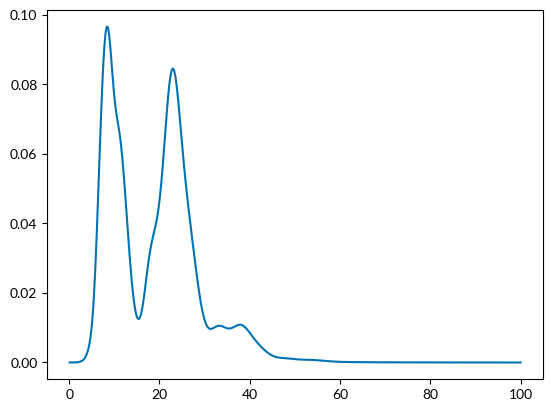

In [181]:
plt.plot(times, evolution_det_fim)

In [179]:
times[np.argmax(evolution_det_fim[1:])]

Array(8.308309, dtype=float32)

In [182]:
# array_cumtimes = np.arange(1, 600000, 100)
x_times = np.linspace(0, max_lim_bin, len(all_mean_agg_binned[:]))

factor_det = 1 / jnp.nanmax(evolution_det_fim[1:])
det_opt_scaling = factor_det / x_times


factor_inverse_matrix = jnp.diag(jnp.nanmin(evolution_inverse_fim[1:], axis=0))
inverse_matrix_scaling = jnp.einsum(
    "i, k -> ki", factor_inverse_matrix, 1 / x_times
)

/tmp/ipykernel_159826/569671560.py:10: RuntimeWarning: divide by zero encountered in divide
  "i, k -> ki", factor_inverse_matrix, 1 / x_times


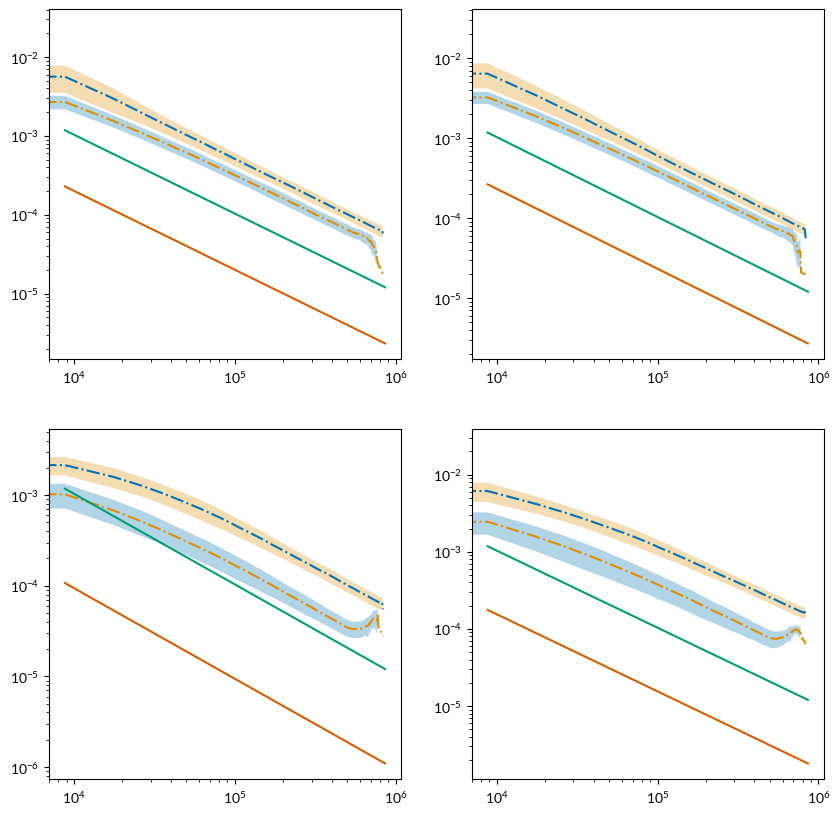

In [183]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i, ax in enumerate(axs.flat):
    ax.plot(
        x_times,
        random_mean_agg_binned[:, i, i],
        "-.",
    )

    ax.plot(
        x_times,
        det_mean_agg_binned[:, i, i],
        "-.",
    )

    ax.fill_between(
        # np.arange(len(all_mean_agg_binned[:, 0, 0])),
        np.linspace(0, max_lim_bin, len(det_mean_agg_binned[:, i, i])),
        det_mean_agg_binned[:, i, i] - det_std_agg_binned[:, i, i],
        det_mean_agg_binned[:, i, i] + det_std_agg_binned[:, i, i],
        alpha=0.3,
    )

    ax.fill_between(
        # np.arange(len(all_mean_agg_binned[:, 0, 0])),
        np.linspace(0, max_lim_bin, len(random_mean_agg_binned[:, i, i])),
        random_mean_agg_binned[:, i, i] - random_std_agg_binned[:, i, i],
        random_mean_agg_binned[:, i, i] + random_std_agg_binned[:, i, i],
        alpha=0.3,
    )
    ax.plot(x_times, det_opt_scaling)
    ax.plot(x_times, inverse_matrix_scaling[:, i])
    ax.set_xscale("log")
    ax.set_yscale("log")

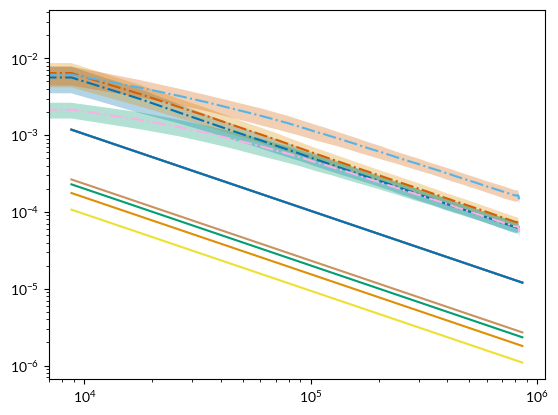

In [155]:
for i in range(4):
    plt.plot(
        x_times,
        all_mean_agg_binned[:, i, i],
        "-.",
    )
    plt.fill_between(
        # np.arange(len(all_mean_agg_binned[:, 0, 0])),
        np.linspace(0, max_lim_bin, len(all_mean_agg_binned[:, i, i])),
        all_mean_agg_binned[:, i, i] - all_std_agg_binned[:, i, i],
        all_mean_agg_binned[:, i, i] + all_std_agg_binned[:, i, i],
        alpha=0.3,
    )
    plt.plot(x_times, det_opt_scaling)
    plt.plot(x_times, inverse_matrix_scaling[:, i])


plt.xscale("log")
plt.yscale("log")

In [6]:
method = "Unoptimized"


def make_df_var_plotting(results_object, method):
    df = results_object
    cov_arr = df.cov_array[:, 1:]
    cumulative_times_per_run = (
        vmap(jnp.cumsum, in_axes=(0))(df.times_array) * 10
    )[:, 1:]

    var_arr = vmap(vmap(lambda x: jnp.diag(x), in_axes=(0)), in_axes=(0))(
        cov_arr
    )

    list_of_individual_df = []
    for i in range(len(var_arr)):
        for j in range(4):
            df_aux = pd.DataFrame(var_arr[i, :, j])
            # df_aux.columns = ["Var 1", "Var 2", "Var 3", "Var_4"]
            df_aux.columns = ["Var"]
            df_aux["ctime"] = cumulative_times_per_run[i]
            df_aux["Method"] = method

            df_aux["Run"] = i
            df_aux["Parameter"] = j
            list_of_individual_df.append(df_aux)

    df_cumulative = pd.concat(list_of_individual_df, axis=0)
    return df_cumulative

In [7]:
df_unoptimized = make_df_var_plotting(run_results_random_times, "Unoptimized")
df_det = make_df_var_plotting(run_results_det_optimized, "Det optimized")
df_both = pd.concat([df_unoptimized, df_det], axis=0)

run_results_random_times = None
run_model_det_optimized = None

In [9]:
df_both["ctime"] = pd.to_timedelta(df_both.ctime, unit="ns")

df_grouped = (
    df_both.groupby(
        [
            df_both.ctime.dt.floor("1000ns"),
            df_both.Run,
            df_both.Parameter,
            df_both.Method,
        ]
    )
    .agg({"Var": ["mean", "std"]})
    .reset_index()
)

In [23]:
df_grouped.columns

MultiIndex([(    'ctime',     ''),
            (      'Run',     ''),
            ('Parameter',     ''),
            (   'Method',     ''),
            (      'Var', 'mean'),
            (      'Var',  'std')],
           )

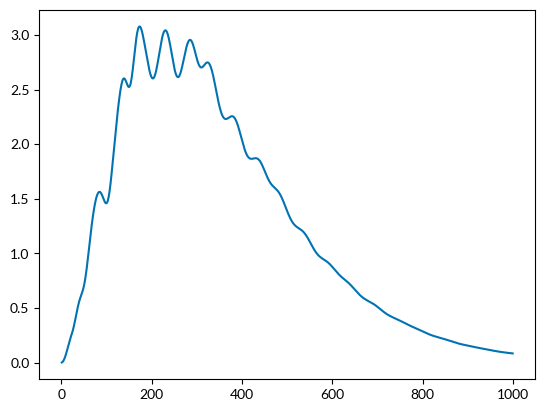

In [24]:
plt.plot(evolution_fim[:, 2, 2])

In [31]:
array_cumtimes = df_both.ctime.to_numpy().astype("float")

In [57]:
array_cumtimes = np.arange(1, 600000, 100)

factor_det = 1 / jnp.nanmax(evolution_det_fim)
det_opt_scaling = factor_det / array_cumtimes


factor_inverse_matrix = jnp.diag(jnp.nanmin(evolution_inverse_fim[1:], axis=0))
inverse_matrix_scaling = jnp.einsum(
    "i, k -> ki", factor_inverse_matrix, 1 / array_cumtimes
)

In [24]:
df_grouped.Run.unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [36]:
data.agg({["Run", ""]: ["mean"]})

TypeError: unhashable type: 'list'

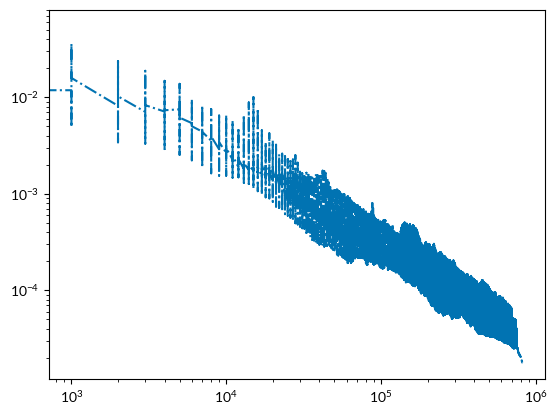

In [29]:
data = df_grouped[
    (df_grouped.Parameter == 0) & (df_grouped.Method == "Det optimized")
]
plt.plot(data[("ctime", "")], data[("Var", "mean")], "-.")
plt.yscale("log")
plt.xscale("log")

In [58]:
inverse_matrix_scaling

Array([[2.0093334e+00, 2.3272505e+00, 9.4143891e-01, 1.5490515e+00],
       [1.9894389e-02, 2.3042083e-02, 9.3211774e-03, 1.5337143e-02],
       [9.9966833e-03, 1.1578361e-02, 4.6837754e-03, 7.7067236e-03],
       ...,
       [3.3505585e-06, 3.8806847e-06, 1.5698471e-06, 2.5830398e-06],
       [3.3500000e-06, 3.8800376e-06, 1.5695855e-06, 2.5826091e-06],
       [3.3494416e-06, 3.8793910e-06, 1.5693238e-06, 2.5821785e-06]],      dtype=float32)

In [ ]:
# array_cumtimes = (
#     df_grouped[
#         (df_grouped.Parameter == names_true[0])
#         & (df_grouped.Cols == "Variance")
#     ]
#     .Time.to_numpy()
#     .astype("float")
# )

In [37]:
def aux_plot(i, *args, **kwargs):
    x = array_cumtimes
    y1 = det_opt_scaling
    y2 = inverse_matrix_scaling

    plt.plot(
        x,
        y1,
        "-.",
        label="det scaling$",
        alpha=0.7,
    )
    plt.plot(
        x,
        y2[:, i],
        "-.",
        label="Inverse ",
        alpha=0.7,
    )

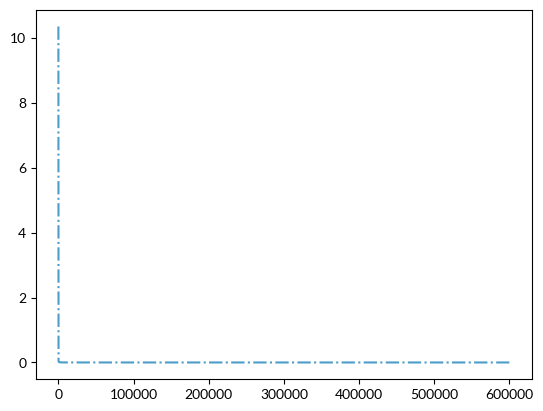

In [59]:
plt.plot(
    array_cumtimes,
    det_opt_scaling,
    "-.",
    label="det scaling$",
    alpha=0.7,
)

In [49]:
array_cumtimes

array([     0,    100,    200, ..., 599700, 599800, 599900])

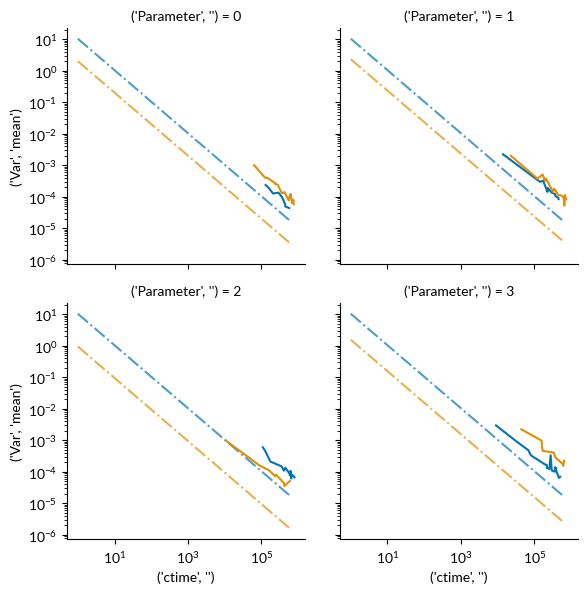

In [61]:
sns.set_palette("colorblind")

g = sns.FacetGrid(
    data=df_grouped.sample(100),
    col=("Parameter", ""),
    col_wrap=2,
)
axes = g.axes.flatten()
for i in range(4):
    axes[i].plot(
        array_cumtimes,
        det_opt_scaling,
        "-.",
        label="det scaling$",
        alpha=0.7,
    )
    axes[i].plot(
        array_cumtimes,
        inverse_matrix_scaling[:, i],
        "-.",
        label="Inverse ",
        alpha=0.7,
    )
    # g.map_dataframe(aux_plot, i)

g.map_dataframe(
    sns.lineplot,
    x=("ctime", ""),
    y=("Var", "mean"),
    errorbar="sd",
    hue="Method",
)


# axes[i].set_title(names_true[i])
# axes[i].set_ylabel("Var")


plt.xscale("log")
plt.yscale("log")

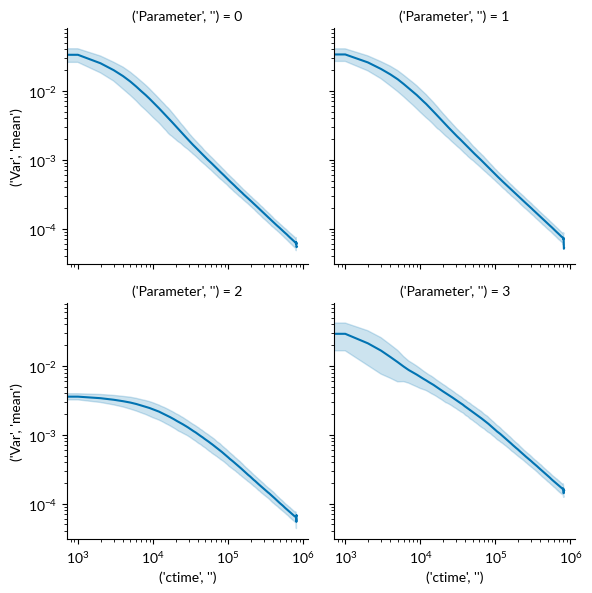

In [115]:
g = sns.FacetGrid(
    data=ejemplo,
    col=("Parameter", ""),
    col_wrap=2,
)

g.map_dataframe(
    sns.lineplot,
    # data=ejemplo.sample(1000),
    x=("ctime", ""),
    y=("Var", "mean"),
    errorbar="sd",
)
plt.xscale("log")
plt.yscale("log")

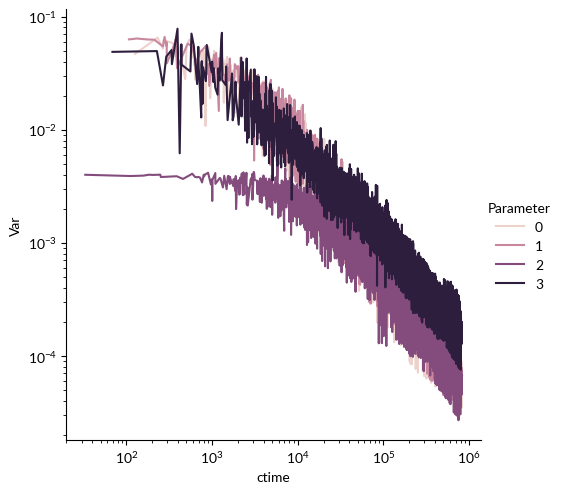

In [76]:
sns.relplot(
    data=df_cumulative.sample(100000),
    x="ctime",
    y="Var",
    hue="Parameter",
    kind="line",
)
plt.xscale("log")
plt.yscale("log")

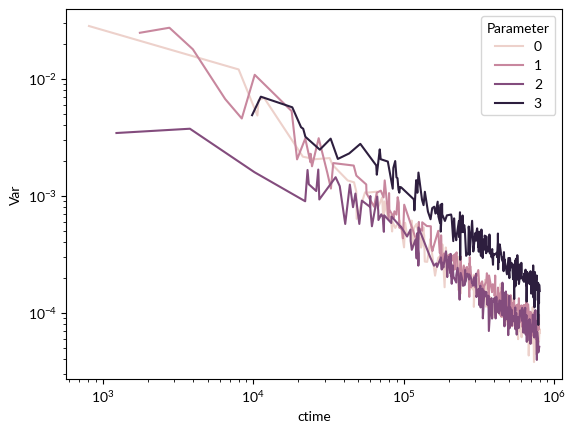

In [71]:
sns.lineplot(
    data=df_cumulative.sample(1000), x="ctime", y="Var", hue="Parameter"
)
plt.xscale("log")
plt.yscale("log")

In [39]:
df_cumulative.groupby(df_cumulative.ctime.dt.floor("1000ns"))

AttributeError: Can only use .dt accessor with datetimelike values

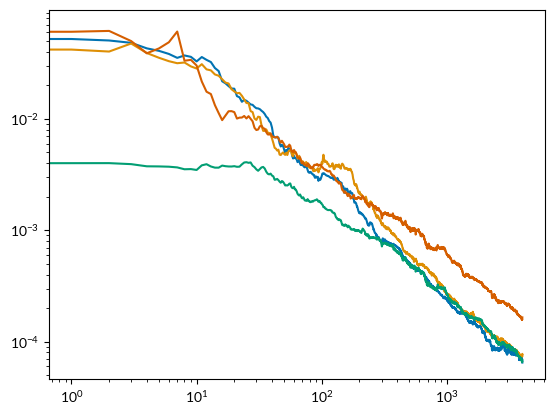

In [17]:
plt.plot(var_arr[0, :, :])
plt.yscale("log")
plt.xscale("log")

In [13]:
var_arr.shape

(500, 3999, 4)